In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader

from dataloader.ts_reader import MultiModalDataset, collate_fn
from dataloader.pyg_reader import GraphDataset
from model.final_model_loss_train import *
from model.final_model import PatientOutcomeModel
from model.rnn_baseline import BaselineRNN

import numpy as np 
import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.synchronize()

from torch.amp import GradScaler, autocast
scaler = GradScaler() 


In [3]:
# === LSTM + Flat Dataset ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

lstm_dataset_train = MultiModalDataset(train_data_dir)
lstm_dataset_val = MultiModalDataset(val_data_dir)
lstm_dataset_test = MultiModalDataset(test_data_dir)

train_loader = DataLoader(lstm_dataset_train , batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(lstm_dataset_val , batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(lstm_dataset_test , batch_size=16, shuffle=False, collate_fn=collate_fn)

config = {  
    "data_dir": "/home/mei/nas/docker/thesis/data/hdf",
    "graph_dir": "/home/mei/nas/docker/thesis/data/graphs",
    "mode": "k_closest",
    "k": 3         
}
graph_dataset = GraphDataset(config)


==> Loading precomputed graph from /home/mei/nas/docker/thesis/data/graphs/diagnosis_graph_k_closest_k3.pt
==> Loading flat features from /home/mei/nas/docker/thesis/data/hdf/final_flat.h5


In [6]:
save_path = '/home/mei/nas/docker/thesis/data/model_results/final_model/best_model_rnn.pth'
history_path = '/home/mei/nas/docker/thesis/data/model_results/final_model/history_rnn.json'

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


pretrained = BaselineRNN( n_features=154, embedding_dim=128, grid_size=(12,12)).to(device)
pretrained.load_state_dict(torch.load("/home/mei/nas/docker/thesis/data/model_results/rnn_baseline/stage2/best_joint_model.pth",weights_only=True ))

pretrained_encoder = pretrained.encoder
som = pretrained.som

model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
for param in model.som_layer.parameters():
    param.requires_grad = False  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:
model,history = train_patient_outcome_model(model, train_loader, val_loader, graph_dataset.graph_data,optimizer, device, n_epochs=100, save_path=save_path, history_path=history_path,patience=50)

Epoch 10: Train 0.4204, Val 0.3996
Epoch 20: Train 0.3650, Val 0.4493
Epoch 30: Train 0.3334, Val 0.4222
Epoch 40: Train 0.3186, Val 0.4373
Epoch 50: Train 0.2928, Val 0.4203
Epoch 60: Train 0.2496, Val 0.5033
Early stopping triggered.


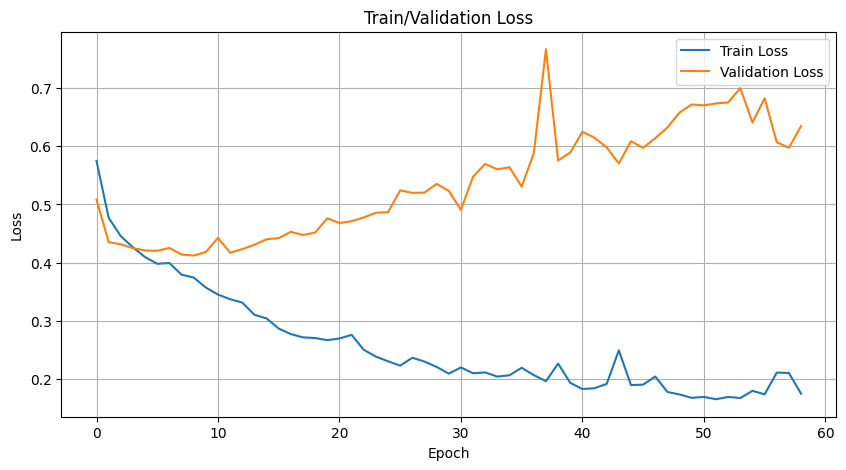

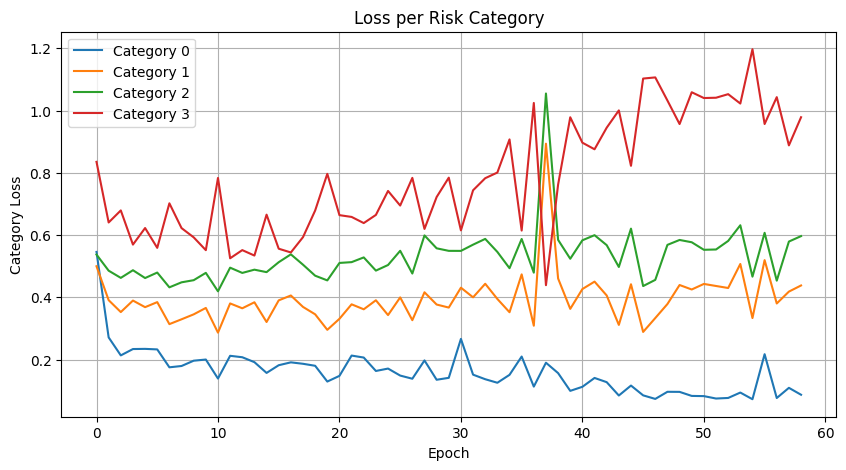

In [5]:
plot_training_history(history)

In [6]:
# model.load_state_dict(torch.load('/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth',weights_only=True))
result = evaluate_model_on_test_set(model, test_loader, graph_dataset.graph_data, device)

[Test] Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.51it/s]


[Test] Evaluation Summary:
  Overall Test Loss: 0.5359
  Risk Category 0: Mean Loss = 0.1381, Count = 27
  Risk Category 1: Mean Loss = 0.3075, Count = 294
  Risk Category 2: Mean Loss = 0.6040, Count = 89
  Risk Category 3: Mean Loss = 1.1148, Count = 51


In [4]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

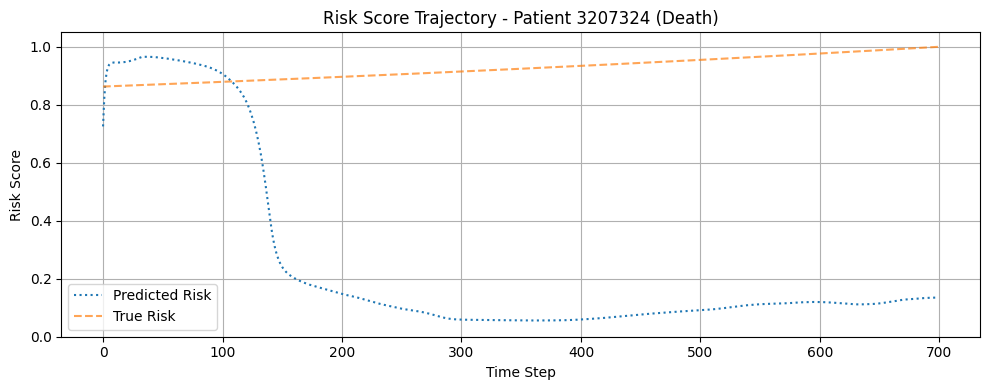

In [11]:
plot_patient_risk_trajectory(model, test_loader, patient_index=400, graph_data=graph_dataset.graph_data, device=device)

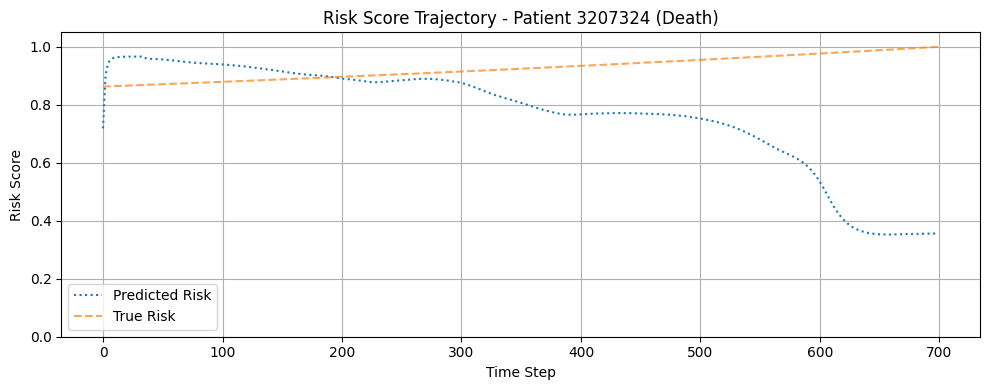

In [5]:
plot_patient_risk_trajectory(model, test_loader, patient_index=400, graph_data=graph_dataset.graph_data, device=device)

In [ ]:
def collect_k_and_risk_from_model(model, loader, graph_data, device, som_grid=(12, 12)):
    """

    """
    model.eval()
    all_k, all_risk = [], []
    grid_h, grid_w = som_grid

    with torch.no_grad():
        for batch in loader:
            patient_ids, flat_data, ts_data, risk_data, lengths, _ = batch
            flat_data, ts_data, lengths = flat_data.to(device), ts_data.to(device), lengths.to(device)
            patient_ids = [int(pid) for pid in patient_ids]

            # === 模型前向 ===
            risk_pred, ts_emb, som_z, aux_info = model(flat_data, graph_data, patient_ids, ts_data, lengths)

            bmu_indices = aux_info['bmu_indices']  # [B, T]
            B, T = bmu_indices.shape

            for i in range(B):
                L = lengths[i].item()
                bmu_seq = bmu_indices[i, :L]
                risk_seq = risk_pred[i, :L]

                k_x = bmu_seq % grid_w
                k_y = bmu_seq // grid_w
                k = torch.stack([k_x, k_y], dim=-1)  # [L, 2]

                all_k.append(k.cpu())
                all_risk.append(risk_seq.cpu())

    return all_k, all_risk

def plot_som_risk_heatmap_v2(k_list, risk_list, som_grid=(12, 12), title="SOM Risk Heatmap"):
    """
    """
    k_tensor = torch.nn.utils.rnn.pad_sequence(k_list, batch_first=True, padding_value=-1)  # [N, T, 2]
    risk_tensor = torch.nn.utils.rnn.pad_sequence(risk_list, batch_first=True, padding_value=-1)  # [N, T]

    k_tensor = k_tensor.numpy()
    risk_tensor = risk_tensor.numpy()

    grid_h, grid_w = som_grid
    risk_sum = np.zeros((grid_h, grid_w))
    risk_count = np.zeros((grid_h, grid_w))

    N, T, _ = k_tensor.shape
    for i in range(N):
        for t in range(T):
            if k_tensor[i, t, 0] == -1:  # 跳过padding
                continue
            x, y = k_tensor[i, t]
            x, y = int(x), int(y)
            if 0 <= x < grid_h and 0 <= y < grid_w:
                risk_sum[x, y] += risk_tensor[i, t]
                risk_count[x, y] += 1

    with np.errstate(divide='ignore', invalid='ignore'):
        avg_risk = np.divide(risk_sum, risk_count, out=np.zeros_like(risk_sum), where=risk_count > 0)

    plt.figure(figsize=(6, 6))
    sns.heatmap(avg_risk, cmap='Reds', square=True, cbar_kws={'label': 'Average Risk Score'})
    plt.title(title, fontsize=14)
    plt.xlabel("SOM X", fontsize=12)
    plt.ylabel("SOM Y", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

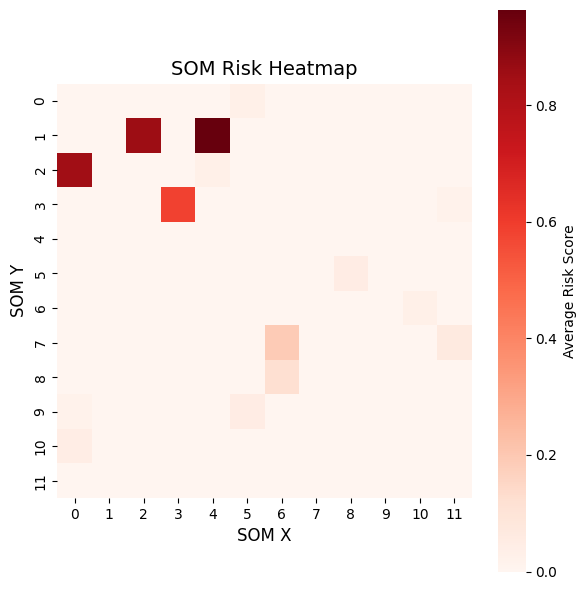

In [9]:
k_list, risk_list = collect_k_and_risk_from_model(
    model=model,
    loader=test_loader,
    graph_data=graph_dataset.graph_data,
    device=device,
    som_grid=(12, 12)
)

plot_som_risk_heatmap_v2(k_list, risk_list, som_grid=(12, 12), title="SOM Risk Heatmap")


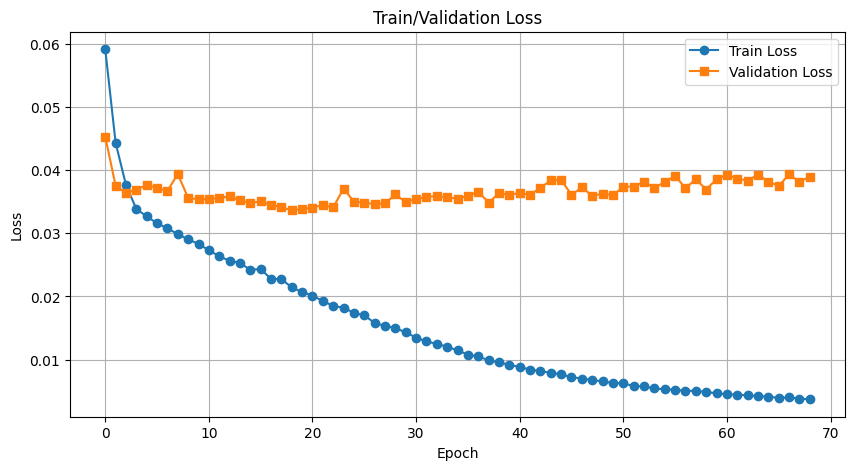

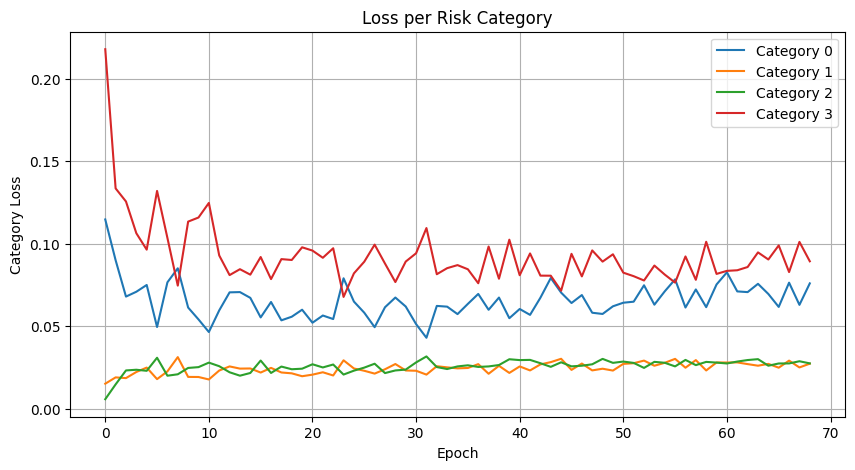

In [23]:
plot_training_history(history)

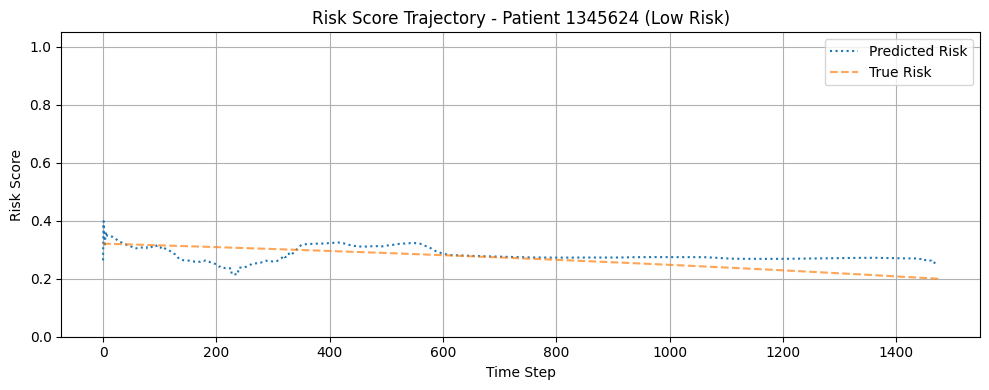

In [25]:
plot_patient_risk_trajectory(model, test_loader, patient_index=32, graph_data=graph_dataset.graph_data, device=device)

In [ ]:
def collect_k_and_category(model, loader, graph_data, device):
    model.eval()
    all_k, all_cat, all_risk = [], [], []

    with torch.no_grad():
        for batch in loader:
            patient_ids, flat_data, ts_data, risk_data, lengths, categories = batch
            flat_data = flat_data.to(device)
            ts_data = ts_data.to(device)
            lengths = lengths.to(device)

            patient_ids = [int(pid) for pid in patient_ids]
            categories = categories.to(device)

            # forward
            risk_scores, _, losses = model(flat_data, graph_data, patient_ids, ts_data, lengths)

            if "k" in losses:
                all_k.extend([k.cpu() for k in losses["k"]])
                all_cat.extend(categories.cpu().tolist())
                all_risk.extend([rs[:l].cpu() for rs, l in zip(risk_scores, lengths)])

    return all_k, all_risk, all_cat


def plot_som_risk_heatmap(k_tensor, risk_tensor, som_grid=(10, 10)):
    # Defensive check and conversion
    if isinstance(k_tensor, list):
        k_tensor = [torch.tensor(k) if not isinstance(k, torch.Tensor) else k for k in k_tensor]
        k_tensor = torch.nn.utils.rnn.pad_sequence(k_tensor, batch_first=True)
    if isinstance(risk_tensor, list):
        risk_tensor = [torch.tensor(r) if not isinstance(r, torch.Tensor) else r for r in risk_tensor]
        risk_tensor = torch.nn.utils.rnn.pad_sequence(risk_tensor, batch_first=True)

    k_tensor = k_tensor.cpu().numpy()
    risk_tensor = risk_tensor.cpu().numpy()

    grid_h, grid_w = som_grid
    risk_sum = np.zeros((grid_h, grid_w))
    risk_count = np.zeros((grid_h, grid_w))

    N, T = risk_tensor.shape
    for i in range(N):
        for t in range(T):
            x, y = k_tensor[i, t]
            x, y = int(x), int(y)
            if 0 <= x < grid_h and 0 <= y < grid_w:
                risk_sum[x, y] += risk_tensor[i, t]
                risk_count[x, y] += 1

    with np.errstate(divide='ignore', invalid='ignore'):
        avg_risk = np.divide(risk_sum, risk_count, out=np.zeros_like(risk_sum), where=risk_count > 0)

    plt.figure(figsize=(6, 6))
    sns.heatmap(avg_risk, cmap='Reds', square=True, cbar_kws={'label': 'Average Risk Score'})
    plt.title("SOM Heatmap of Average Risk Score")
    plt.xlabel("SOM X")
    plt.ylabel("SOM Y")
    plt.tight_layout()
    plt.show()

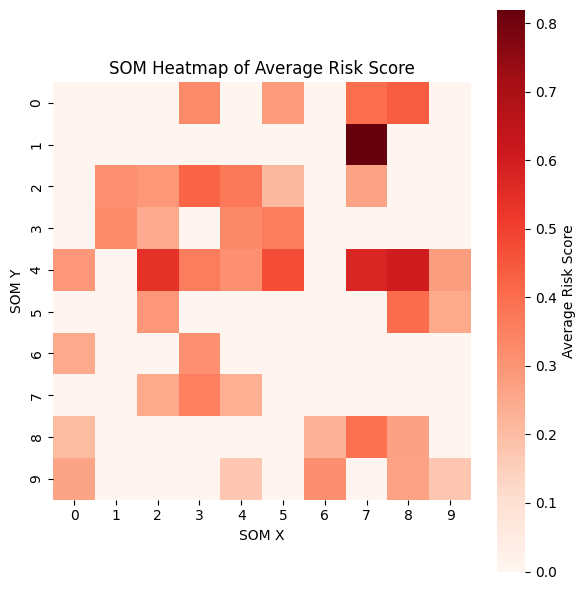

In [27]:
# model.load_state_dict(torch.load('/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth',weights_only=True))

k_tensor, risk_tensor, cat_tensor = collect_k_and_category(model, test_loader, graph_dataset.graph_data, device)
plot_som_risk_heatmap(k_tensor, risk_tensor, som_grid=(10, 10))